<a href="https://colab.research.google.com/github/MeenMeen2002/Mini-project/blob/main/6410210598.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers

In [19]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [21]:
import cv2
import glob
import numpy as np

# Define file paths
path_No = '/content/drive/MyDrive/Mini project/mini project/mini project/no/*.jpg'
path_Yes = '/content/drive/MyDrive/Mini project/mini project/mini project/yes/*.jpg'

tumor = []
no_tumor = []

# Load images from path_Yes
for file in glob.iglob(path_Yes):
    img = cv2.imread(file)
    if img is not None:  # Check if image is loaded successfully
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        tumor.append((img, 1))

# Load images from path_No
for file in glob.iglob(path_No):
    img = cv2.imread(file)
    if img is not None:  # Check if image is loaded successfully
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        no_tumor.append((img, 0))

# Concatenate the two lists and shuffle the data
all_data = tumor + no_tumor
np.random.seed(42)
np.random.shuffle(all_data)

# Split data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])


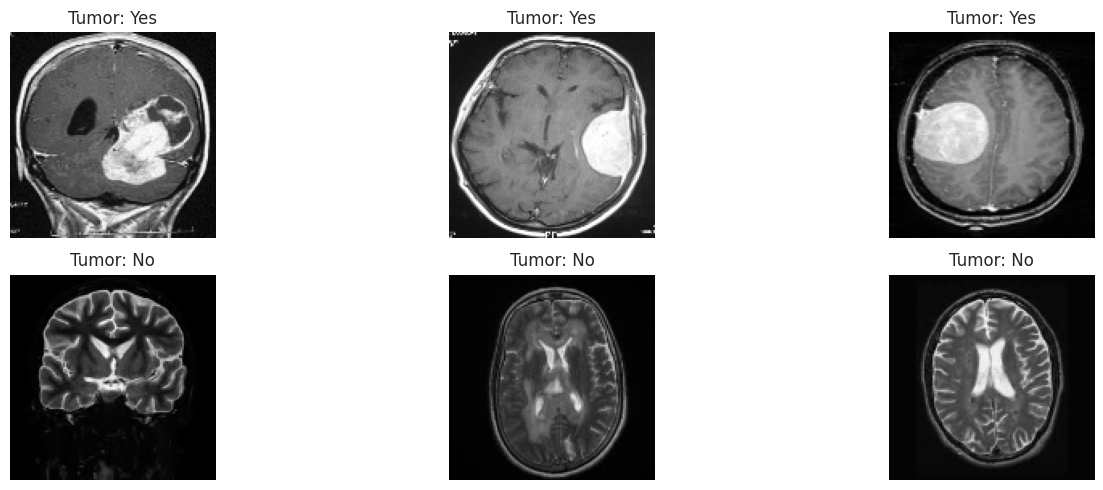

In [22]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

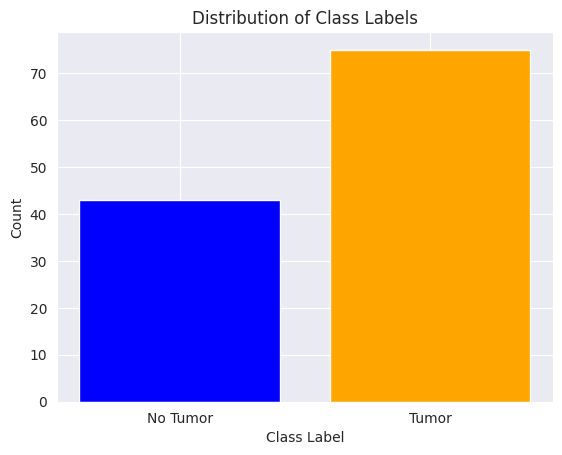

In [23]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [24]:
def crop_brain_region(image, size):

    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)

    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)

    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)

    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)

    return contour_image, bounding_box_image, cropped_image, resized_image

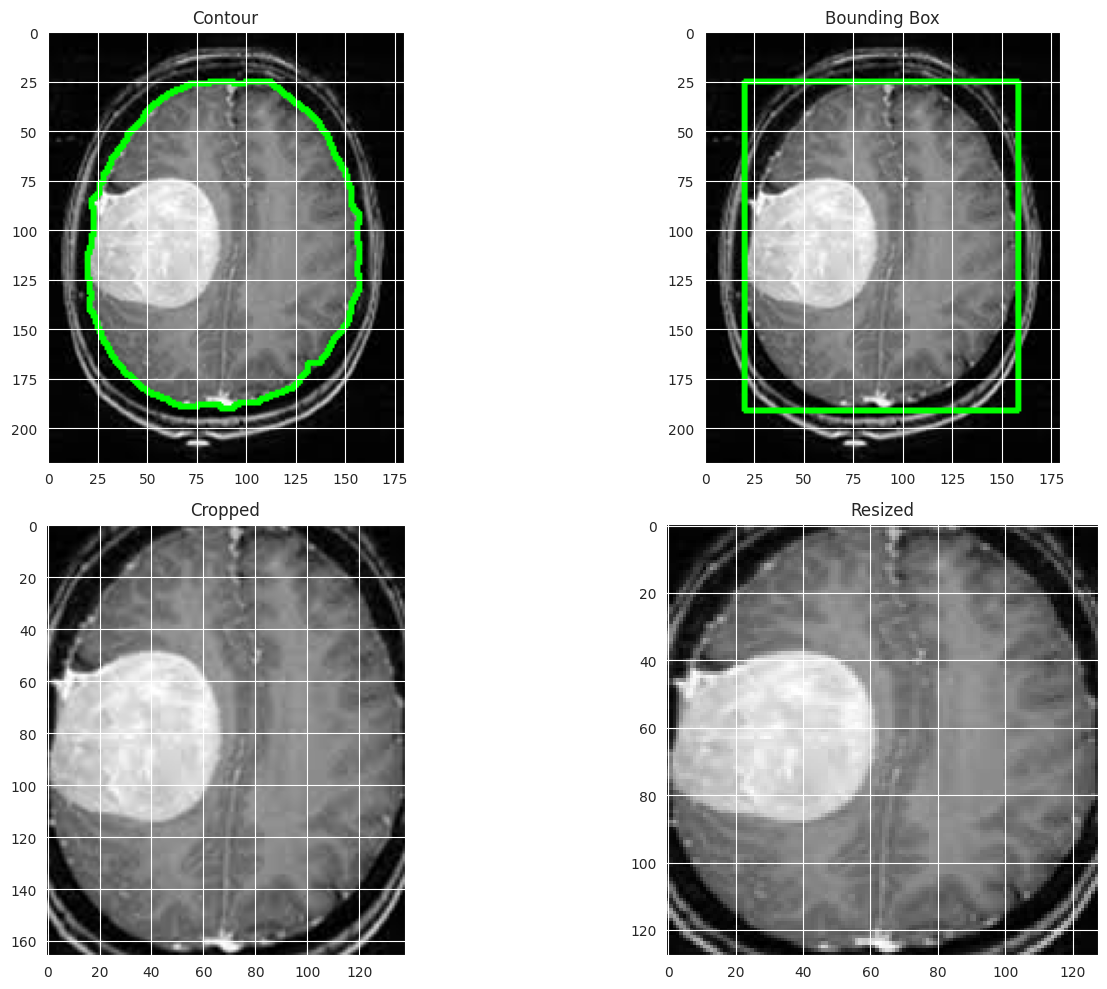

In [26]:

output_size = (128, 128)

example_image = cv2.imread('/content/drive/MyDrive/Mini project/mini project/mini project/yes/Y1.jpg')
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in data:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

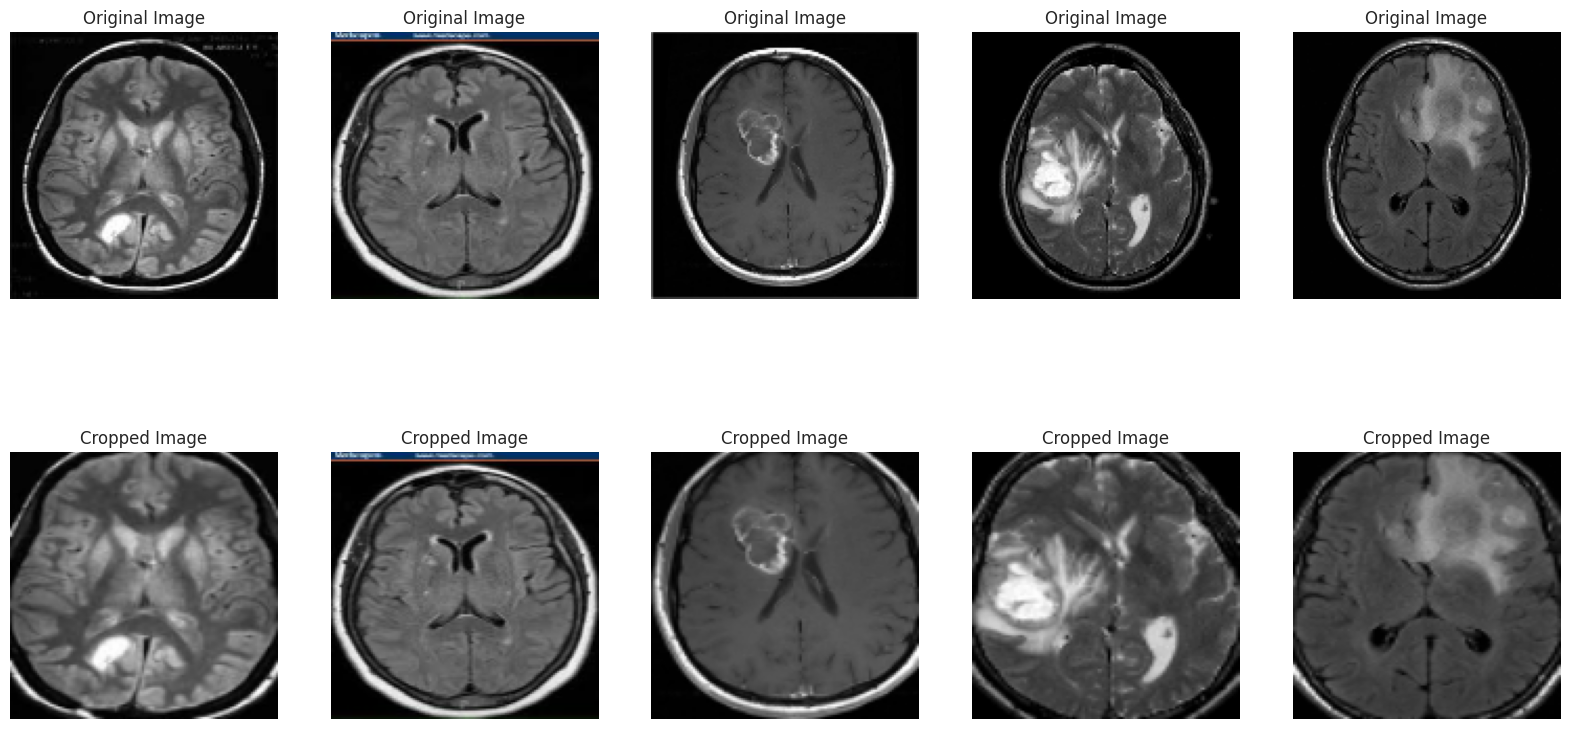

In [27]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(data[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()

Data Splitting

In [28]:
all_cropped=np.array(all_cropped)

In [29]:
# Shuffling the data to make sure the images are randomized and there is no order in labels
all_cropped_shuffled, labels_shuffled = shuffle(all_cropped, labels, random_state=42)

train_images, test_images, train_labels, test_labels = train_test_split(all_cropped_shuffled, labels_shuffled, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (94, 128, 128, 3)
Train labels shape: (94,)
Validation data shape: (12, 128, 128, 3)
Validation labels shape: (12,)
Test data shape: (12, 128, 128, 3)
Test labels shape: (12,)


In [30]:
print(np.max(train_images))
print(np.min(train_images))

255
0


In [31]:
train_images=train_images/255
test_images=test_images/255
val_images=val_images/255

In [32]:
print(np.max(train_images))
print(np.min(train_images))

1.0
0.0


Baseline CNN

In [33]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [34]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting


history = model.fit(train_images,
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                   callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 5s 1s/step - loss: 0.6692 - accuracy: 0.6064 - val_loss: 0.5804 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.6481 - accuracy: 0.6596 - val_loss: 0.5704 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.6405 - accuracy: 0.6596 - val_loss: 0.5735 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.6186 - accuracy: 0.6596 - val_loss: 0.5764 - val_accuracy: 0.7500
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.6106 - accuracy: 0.6596 - val_loss: 0.5727 - val_accuracy: 0.7500
Epoch 6/50
3/3 [==============================] - 5s 2s/step - loss: 0.6168 - accuracy: 0.6596 - val_loss: 0.5614 - val_accuracy: 0.7500
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.6158 - accuracy: 0.6596 - val_loss: 0.5521 - val_accuracy: 0.7500
Epoch 8/50
3/3 [=========================

1/1 [==============================] - 0s 225ms/step
Accuracy on Validation Set: 0.750 %


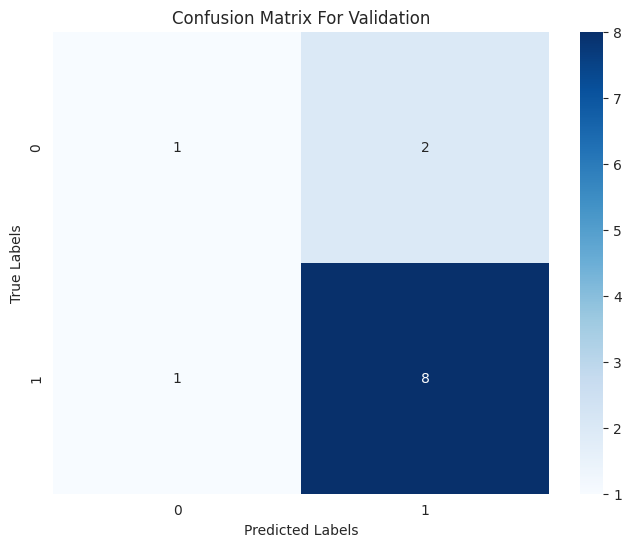

In [35]:
predictions = model.predict(val_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 244ms/step
Accuracy on Test Set: 0.417 %


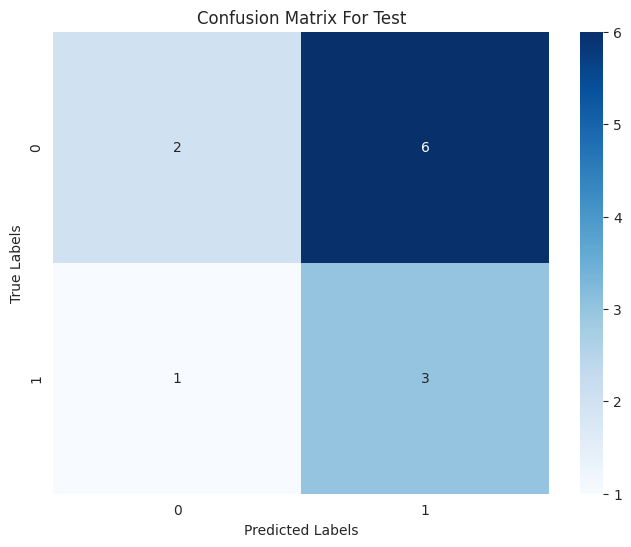

In [36]:
predictions = model.predict(test_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

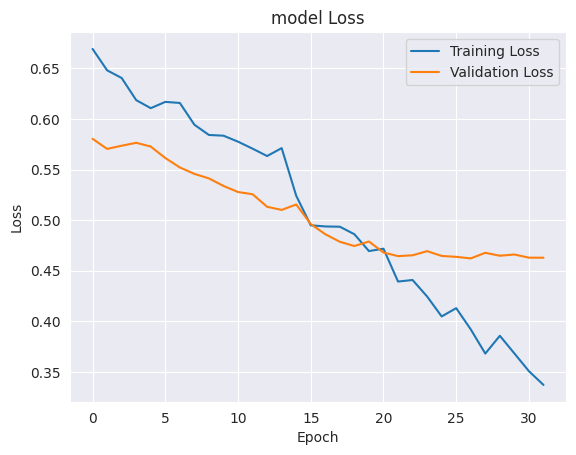

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

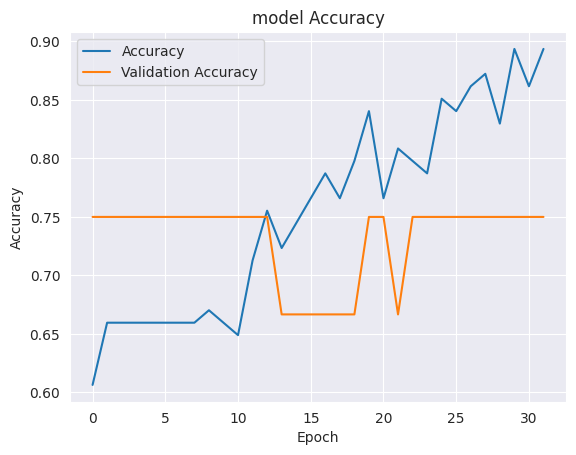

In [38]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

VGG 16

In [44]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

# Load VGG16 model without top layers and specify input shape
base_model = VGG16(include_top=False, input_shape=(128, 128, 3))

# Set the trainable property of the first layer to False (freeze weights)
base_model.layers[0].trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])


58889256/58889256 [==============================] - 2s 0us/step


In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

history = model.fit(train_images,
      train_labels,
    epochs=5,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
3/3 [==============================] - 76s 25s/step - loss: 0.5666 - accuracy: 0.8830 - val_loss: 0.4113 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 2/5
3/3 [==============================] - 74s 25s/step - loss: 0.5208 - accuracy: 0.8617 - val_loss: 0.3886 - val_accuracy: 0.9167 - lr: 1.0000e-05
Epoch 3/5
3/3 [==============================] - 74s 24s/step - loss: 0.4795 - accuracy: 0.8936 - val_loss: 0.3736 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/5
3/3 [==============================] - 75s 25s/step - loss: 0.4551 - accuracy: 0.9149 - val_loss: 0.3530 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 5/5
3/3 [==============================] - 74s 25s/step - loss: 0.4071 - accuracy: 0.9043 - val_loss: 0.3409 - val_accuracy: 1.0000 - lr: 1.0000e-05


1/1 [==============================] - 4s 4s/step
Accuracy on Validation Set: 1.000000


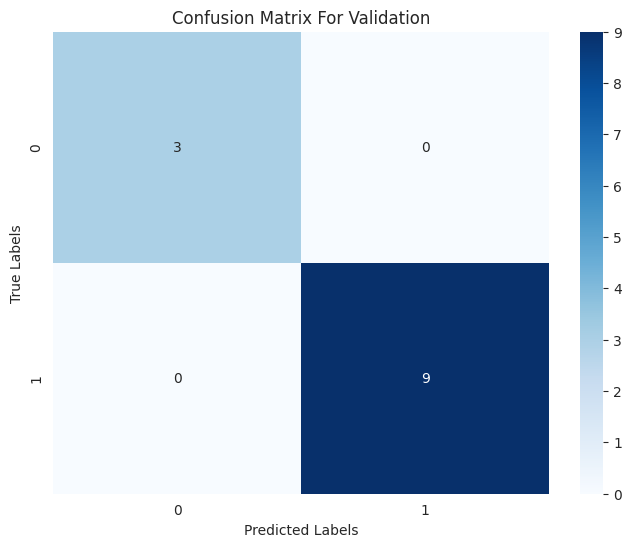

In [53]:
predictions = model.predict(val_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 4s 4s/step
Accuracy on Test Set: 0.833333


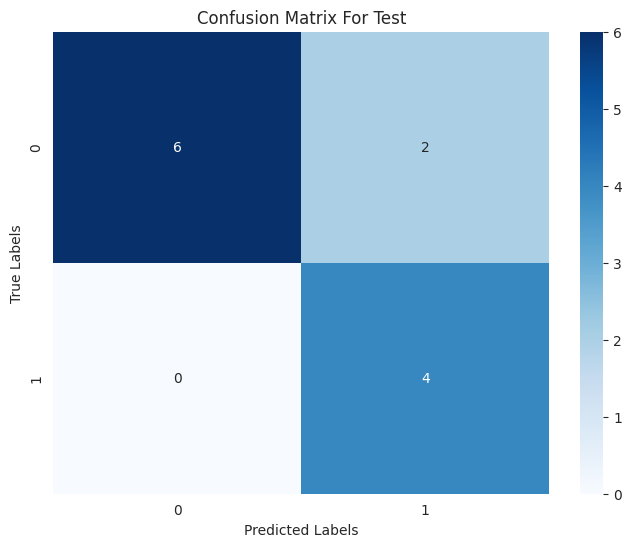

In [54]:
predictions = model.predict(test_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

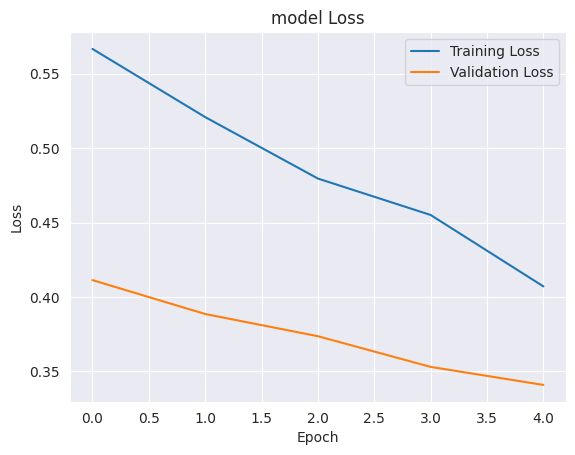

In [55]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

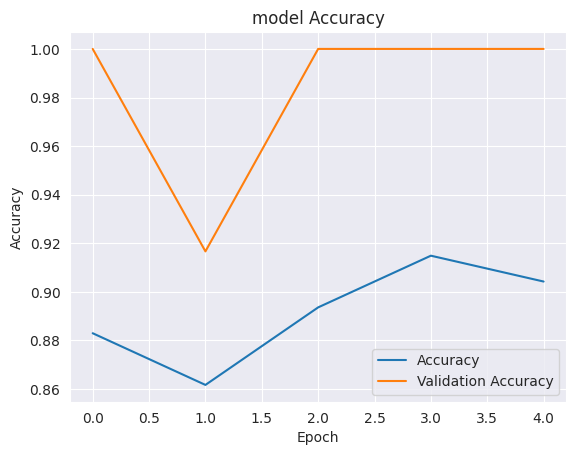

In [56]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()